In [1]:
%load_ext autoreload
%autoreload 2
import numpy as np
from matplotlib import pyplot as plt
import fashion as fsh
import keras
from keract import get_activations

import os
os.environ['KMP_DUPLICATE_LIB_OK']='True'

Using TensorFlow backend.


In [2]:
from keras.layers import Input, Embedding, Dense, Conv2D, Deconvolution2D
from keras.layers import MaxPool2D, Flatten, Concatenate, Reshape, Dropout
from keras.models import Model, Sequential
from keras.optimizers import Adam

In [3]:
images, labels = fsh.read_data(
    'fashion/train-images-idx3-ubyte.gz',
    'fashion/train-labels-idx1-ubyte.gz',
    20000)

test_images, test_labels = fsh.read_data(
    'fashion/t10k-images-idx3-ubyte.gz',
    'fashion/t10k-labels-idx1-ubyte.gz',
    10000
)

images = images/255
images = images[:,0:27,0:27,:]
test_images = test_images/255
test_images = test_images[:,0:27,0:27,:]

semi_images = images[:,:,0:14,:]
test_semi_images = test_images[:,:,0:14,:]

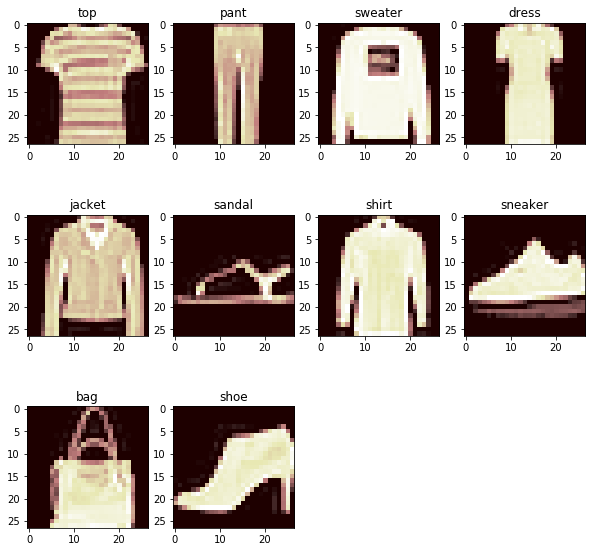

In [4]:
label_dict = {
    0:'top',
    1:'pant',
    2:'sweater',
    3:'dress',
    4:'jacket',
    5:'sandal',
    6:'shirt',
    7:'sneaker',
    8:'bag',
    9:'shoe'
}
fsh.plot_sample_labels(images, labels, label_dict)

In [5]:
image_input = Input(shape = (27,14,1), dtype='float32')

conv_encoder = Conv2D(
    filters = 32,
    kernel_size = (3,3),
    strides = 1,
    activation = 'relu',
    use_bias = True,
    data_format = 'channels_last'
)(image_input)
conv_encoder = Dropout(
    rate = 0.2
)(conv_encoder)
conv_encoder = Conv2D(
    filters = 32,
    kernel_size = (3,3),
    strides = 2,
    activation = 'relu',
    use_bias = True,
    data_format = 'channels_last'
)(conv_encoder)
conv_encoder = Dropout(
    rate = 0.1
)(conv_encoder)
conv_encoder = Flatten(
    data_format = 'channels_last'
)(conv_encoder)

label_input = Input(shape=(1,), dtype='int32')
label_embedding = Embedding(input_dim = 10, output_dim = 2)(label_input)
label_embedding = Flatten()(label_embedding)

encoder = Concatenate()([label_embedding, conv_encoder])

latent = Dense(
    units = 2,
    use_bias=True,
    activation='sigmoid',
    name='latent'
)(encoder)

decoder = Dense(
    units = 12*12*32,
    use_bias=True,
    activation='relu',
    name='decoder_dense_1')(latent)
decoder = Reshape(target_shape=(12, 12, 32))(decoder)
decoder = Dropout(
    rate = 0.1
)(decoder)
decoder = Deconvolution2D(
    filters = 32,
    kernel_size = (3,3),
    strides = 2,
    activation = 'relu',
    use_bias = True,
    data_format = 'channels_last'
)(decoder)
decoder = Dropout(
    rate = 0.2
)(decoder)
decoder = Deconvolution2D(
    filters = 1,
    kernel_size = (3,3),
    strides = 1,
    activation = 'relu',
    use_bias = True,
    data_format = 'channels_last'
)(decoder)

model = Model(inputs=[image_input, label_input], outputs=[decoder])

optimizer = None
model.compile(optimizer='adam',loss='mse')

Epoch 1/10
20000/20000 [==============================] - 45s 2ms/step - loss: 0.1650
Epoch 2/10
20000/20000 [==============================] - 43s 2ms/step - loss: 0.1005
Epoch 3/10
20000/20000 [==============================] - 42s 2ms/step - loss: 0.0894
Epoch 4/10
20000/20000 [==============================] - 42s 2ms/step - loss: 0.0823
Epoch 5/10
20000/20000 [==============================] - 42s 2ms/step - loss: 0.0716
Epoch 6/10
20000/20000 [==============================] - 42s 2ms/step - loss: 0.0623
Epoch 7/10
20000/20000 [==============================] - 42s 2ms/step - loss: 0.0564
Epoch 8/10
20000/20000 [==============================] - 43s 2ms/step - loss: 0.0535
Epoch 9/10
20000/20000 [==============================] - 44s 2ms/step - loss: 0.0514
Epoch 10/10
20000/20000 [==============================] - 44s 2ms/step - loss: 0.0501


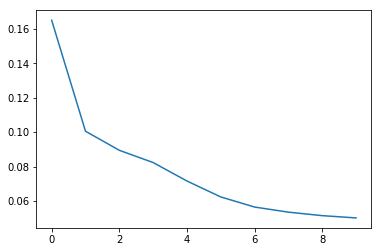

In [7]:
fit = model.fit(
    x=[semi_images, labels],
    y=images,
    epochs=10,
    batch_size=1000
)

plt.plot(fit.history['loss'])

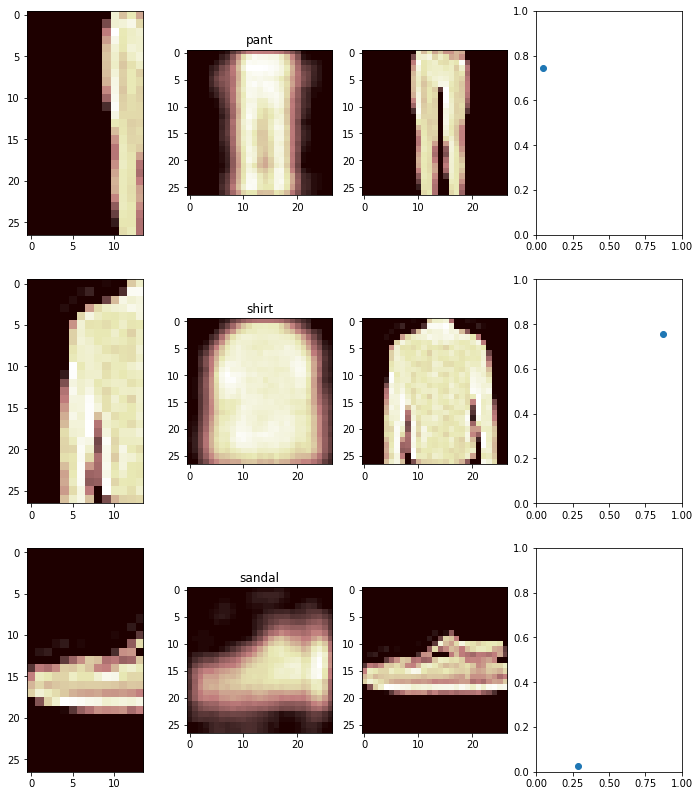

In [9]:
fig = plt.figure(figsize=(12,14))
for i, r in enumerate(np.random.choice(range(len(test_images)),3)):
    inp = [test_semi_images[[r]], test_labels[[r]]]
    pred = model.predict(inp)
    latent_activations = get_activations(model,inp)['latent/Sigmoid:0']
    plt.subplot(3,4,4*i+1)
    fsh.plot_image(test_semi_images[r])
    plt.subplot(3,4,4*i+2)
    fsh.plot_image(pred)
    plt.title(label_dict[test_labels[r]])
    plt.subplot(3,4,4*i+3)
    fsh.plot_image(test_images[r])
    plt.subplot(3,4,4*i+4)
    plt.scatter(
        x=latent_activations[:,0],
        y=latent_activations[:,1]
    )
    plt.xlim(0,1)
    plt.ylim(0,1)

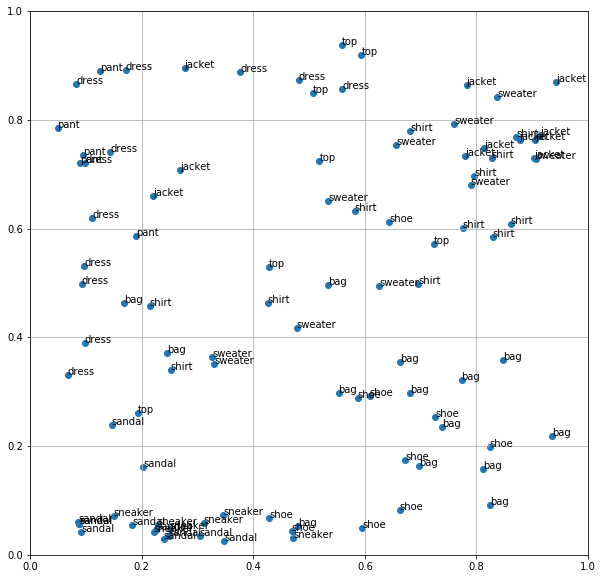

In [11]:
plt.figure(figsize=(10,10))

sample_index = np.random.choice(range(len(test_images)),100)
inp = [test_semi_images[sample_index], test_labels[sample_index]]
latent_activations = get_activations(model,inp)['latent/Sigmoid:0']

x=latent_activations[:,0]
y=latent_activations[:,1]
plt.scatter(x, y)
plt.xlim(0,1)
plt.ylim(0,1)
plt.grid()

for i in range(len(inp[1])):
    plt.annotate(label_dict[inp[1][i]], (x[i],y[i]))

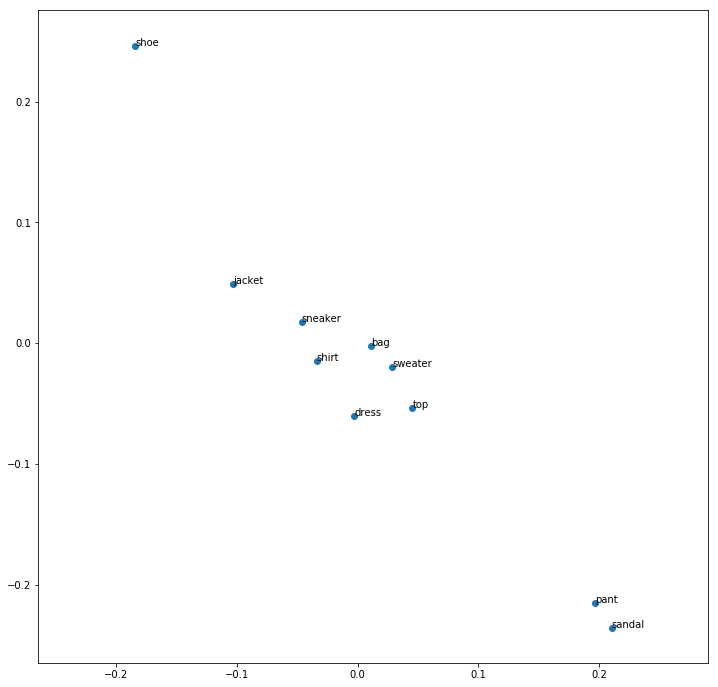

In [12]:
x = model.layers[5].get_weights()[0][:,0]
y = model.layers[5].get_weights()[0][:,1]

plt.figure(figsize=(12,12))
plt.scatter(x, y)
plt.axis('equal')

for txt in label_dict.keys():
    plt.annotate(label_dict[txt], (x[txt], y[txt]))

In [13]:
decoder_model = Sequential(layers=[keras.layers.copy.copy(l) for l in model.layers[11:]])
decoder_model.compile(optimizer='adam',loss='mse')

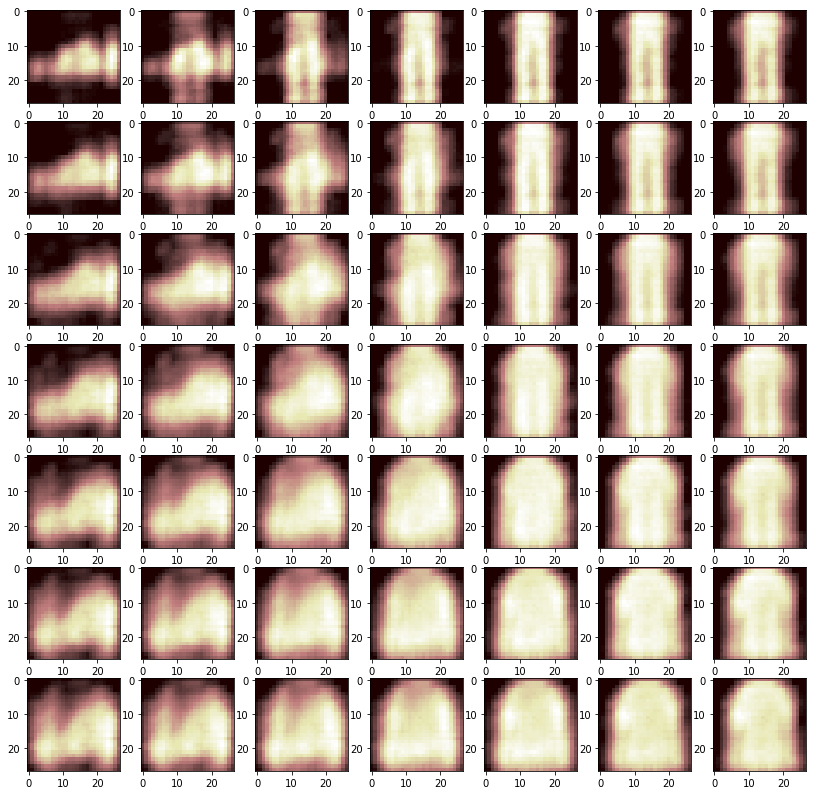

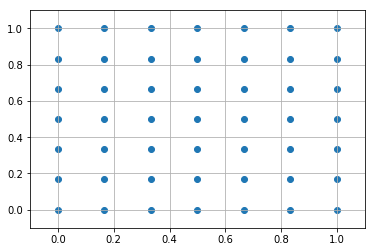

In [14]:
latent_representation = np.array(
    [[i,j] for i in np.linspace(0,1,7) for j in np.linspace(0,1,7)]
)
pred = decoder_model.predict(x=latent_representation)

plt.figure(figsize=(14,14))
cols = int(np.ceil(np.sqrt(pred.shape[0])))
rows = int(np.ceil(pred.shape[0]/cols))
for j in range(cols):
    for i in range(rows):
        plt.subplot(cols,rows,rows*i+j+1)
        fsh.plot_image(pred[rows*i+j])

plt.figure()
plt.scatter(latent_representation[:,0],latent_representation[:,1])
plt.xlim(-0.1,1.1)
plt.ylim(-0.1,1.1)
plt.grid()